# Global Sea Temperatures Between 1972 & 2013
### Global Ocean Data Analysis Project
### National Oceanic and Atmospheric Administration

#### Imports

In [1]:
import pandas as pd
from math import ceil
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
import functools

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline

from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline, NaturalCubicSpline)

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

#### Data Cleaning

In [3]:
df = pd.read_csv('data/0-data/data_product/GLODAPv2 Merged Master File.csv')

In [4]:
key_words = '/Users/erindesmond/Documents/Galvanize/Case-Studies/my_studies/Climate-Temp/1.1/data/0-data'

In [5]:
print(list(df.columns))

['cruise', 'station', 'cast', 'year', 'month', 'day', 'hour', 'minute', 'latitude', 'longitude', 'bottomdepth', 'maxsampdepth', 'bottle', 'pressure', 'depth', 'temperature', 'theta', 'salinity', 'salinityf', 'salinityqc', 'sigma0', 'sigma1', 'sigma2', 'sigma3', 'sigma4', 'gamma', 'oxygen', 'oxygenf', 'oxygenqc', 'aou', 'aouf', 'nitrate', 'nitratef', 'nitrateqc', 'nitrite', 'nitritef', 'silicate', 'silicatef', 'silicateqc', 'phosphate', 'phosphatef', 'phosphateqc', 'tco2', 'tco2f', 'tco2qc', 'talk', 'talkf', 'talkqc', 'phts25p0', 'phts25p0f', 'phtsinsitutp', 'phtsinsitutpf', 'phtsqc', 'cfc11', 'pcfc11', 'cfc11f', 'cfc11qc', 'cfc12', 'pcfc12', 'cfc12f', 'cfc12qc', 'cfc113', 'pcfc113', 'cfc113f', 'cfc113qc', 'ccl4', 'pccl4', 'ccl4f', 'ccl4qc', 'sf6', 'psf6', 'sf6f', 'c13', 'c13f', 'c14', 'c14f', 'c14err', 'h3', 'h3f', 'h3err', 'he3', 'he3f', 'he3err', 'he', 'hef', 'heerr', 'neon', 'neonf', 'neonerr', 'o18', 'o18f', 'toc', 'tocf', 'doc', 'docf', 'don', 'donf', 'tdn', 'tdnf', 'chla', 'chlaf

In [6]:
# Columns to keep. Columns were initially chosen based on repeat column values, and on possible variables of interest.

keep_cols = ['cruise', 'station','year', 'month', 'day', 'hour', 'minute', 'latitude', 'longitude','maxsampdepth','cfc11','cfc12','cfc113','ccl4','temperature','theta',
'salinity', 'oxygen','nitrate','silicate','phosphate','tco2','talk','phts25p0','don','doc','chla','aou']

df = df[keep_cols]

In [7]:
# Convert all rows with -9999 to NaN so they can be dropped.
df = df.replace([-9999, -999, -8888, -888, -7777, -777, -6666, -666],np.NaN)
# df = df.replace(, np.NaN)
# df = df.replace(, np.NaN)
# df = df.replace(, np.NaN)

In [8]:
# Drop duplicated rows

df.duplicated()
df.drop_duplicates(inplace=True);

In [9]:
df['station'].max()

1240880.0

In [10]:
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

# Only include columns that contain any NaN values
df_with_any_null_values = df[df.columns[df.isnull().any()].tolist()]

get_percentage_missing(df_with_any_null_values)

maxsampdepth    0.00
cfc11           0.68
cfc12           0.70
cfc113          0.90
ccl4            0.96
temperature     0.01
theta           0.03
salinity        0.02
oxygen          0.10
nitrate         0.17
silicate        0.17
phosphate       0.23
tco2            0.63
talk            0.68
phts25p0        0.69
don             1.00
doc             0.96
chla            0.96
aou             0.16
dtype: float64

My first question will concern time and temperature. Because the temperature column has only 1% NaN values, I will replace those values with the mean and procede with a hypothesis test.

In [11]:
# Fill NaN values in temperature with mean of temperature

df['temperature'].fillna((df['temperature'].mean()), inplace=True)

In [12]:
max_depth = df['maxsampdepth'].max()
max_depth

7682.0

## EDA of Sea Temperatures Over Time

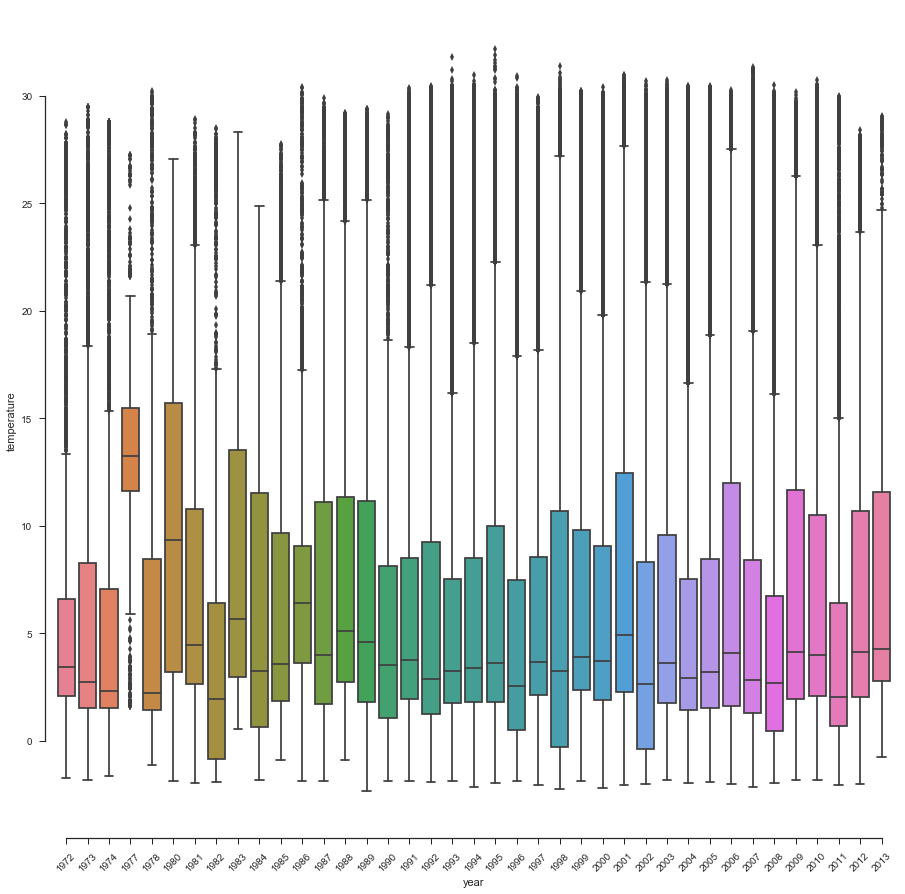

In [24]:
import seaborn as sns
sns.set(style="ticks")

plt.figure(figsize=(15,15))

# Nested boxplot to show temperature over time
sns.boxplot(x='year', y='temperature', data=df, palette="husl")
sns.despine(offset=10, trim=True)
plt.xticks(rotation=45);

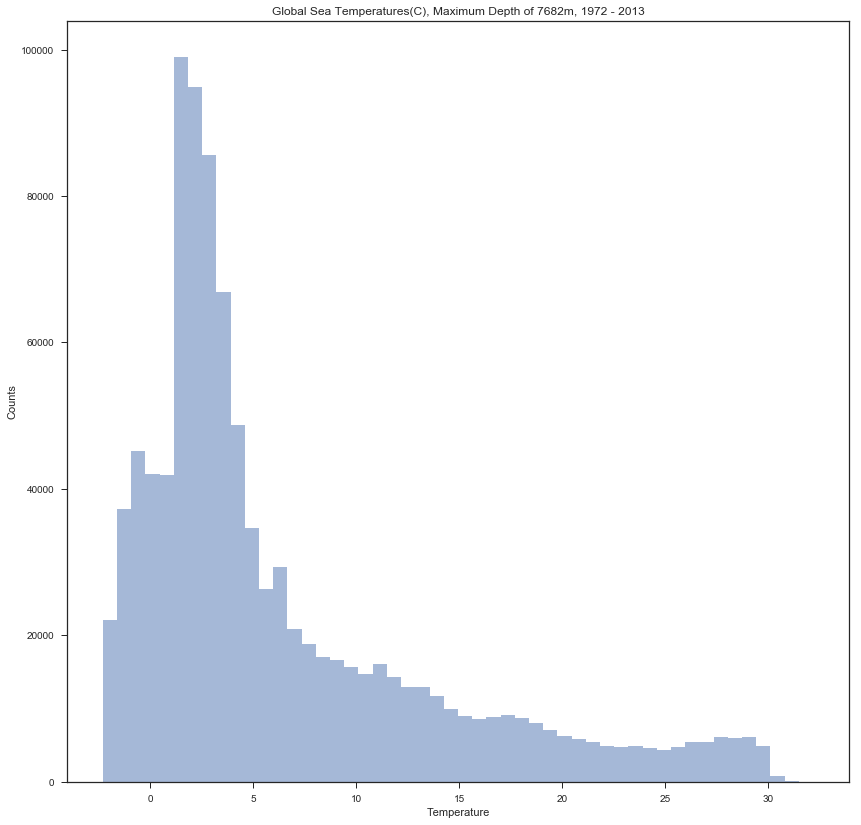

In [14]:
# Histogram of temperature for all years

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
plt.style.use('seaborn-darkgrid')

ax.hist(df['temperature'], bins=50, alpha=0.5)
plt.title('Global Sea Temperatures(C), Maximum Depth of 7682m, 1972 - 2013')
plt.xlabel('Temperature')
plt.ylabel('Counts');

In [15]:
# Create new dataframes with youngest year and oldest year separated

young_year = df[df['year'] == df['year'].min()]
old_year = df[df['year'] == df['year'].max()]

# Check max depth of measurements for those specific years

young_year['maxsampdepth'].max()
old_year['maxsampdepth'].max();

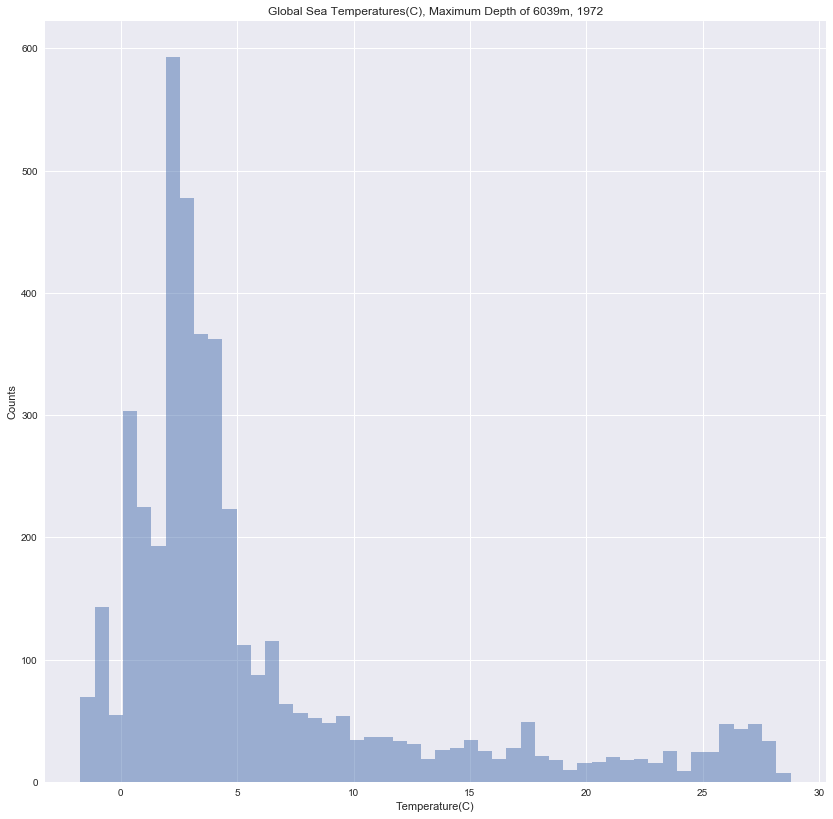

In [16]:
# Barplot of Temperature in 1972

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
plt.style.use('seaborn-darkgrid')


ax.hist(young_year['temperature'], bins=50, alpha=0.5)
plt.title('Global Sea Temperatures(C), Maximum Depth of 6039m, 1972')
plt.xlabel('Temperature(C)')
plt.ylabel('Counts');

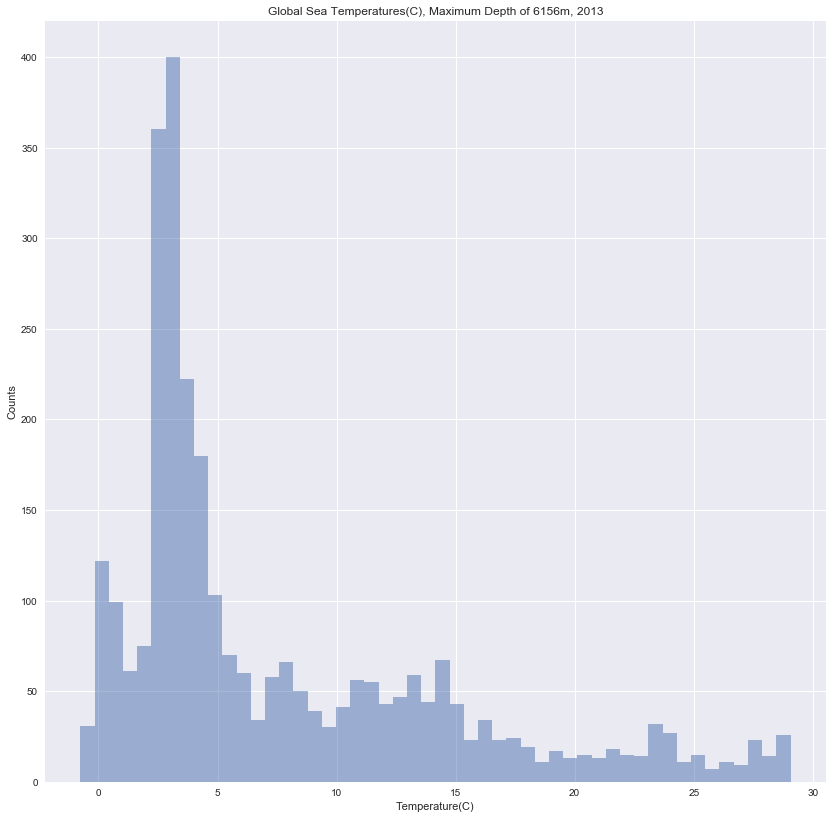

In [17]:
# Plot histogram with temperatures from 2013

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
plt.style.use('seaborn-darkgrid')

ax.hist(old_year['temperature'], bins=50, alpha=0.5)
plt.title('Global Sea Temperatures(C), Maximum Depth of 6156m, 2013')
plt.xlabel('Temperature(C)')
plt.ylabel('Counts');

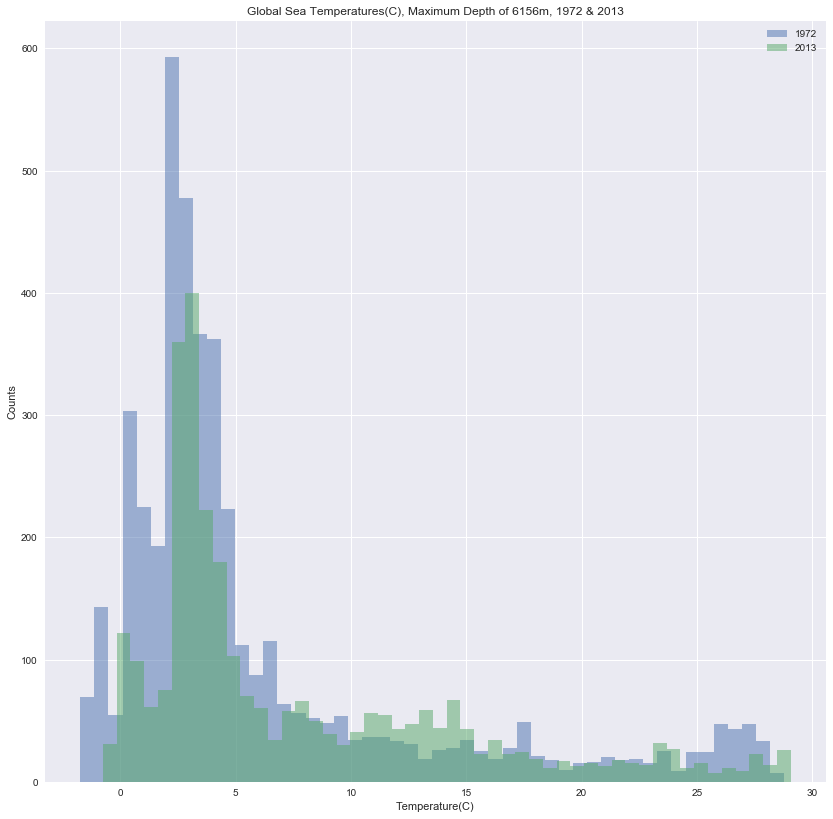

In [18]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)


ax.hist(young_year['temperature'], bins=50, alpha=0.5, label='1972')
ax.hist(old_year['temperature'], bins=50, alpha=0.5, label='2013')
plt.legend(loc='upper right')
plt.xlabel("Temperature(C)")
plt.ylabel('Counts')
plt.title('Global Sea Temperatures(C), Maximum Depth of 6156m, 1972 & 2013')
plt.show()

## Hypothesis Testing

#### Welch's Ttest to Determine if there was a Significant Statistical Change in Temperature from 1972 - 2013

###### Was there a change in average sea temperature measured at a max depth of 7682m between the years of 1972 and 2013?

**Null**: There was no statistically significant change in sea temperature between 1972 & 2013 

**Alternative**: There was a statistically significant change in sea temperature between 1972 & 2013

*Test type*: Welch's two-tailed t-test (Welch's because I am assuming unequal variance between the datasets)

*Alpha*: 0.05

*Significance Level* = 0.025

In [19]:
from scipy import stats

a = young_year['temperature']
b = old_year['temperature']
young_year_mean = a.mean()
old_year_mean = b.mean()

welch_ttest = stats.ttest_ind(a, b, axis=0, equal_var=False)
print("Mean Temperature for 1972: ", young_year_mean)
print("Mean Temperature for 2013: ", old_year_mean)
print("---------------------------------------------")
print("P-value for Welch's T-test: ", welch_ttest[1])
print('---------------------------------------------')
print("Reject Null Hypothesis?: ", welch_ttest[1] <= 0.025)

Mean Temperature for 1972:  5.981127469826658
Mean Temperature for 2013:  7.620444281324687
---------------------------------------------
P-value for Welch's T-test:  1.84628899482e-22
---------------------------------------------
Reject Null Hypothesis?:  True


This is an incredibly small p-value, which suggests a statistically significant change between the two years.

In [20]:
sta_young = df[['station', 'temperature']]
sta_old = df[['station', 'temperature']]

## EDA for Regression Analysis

In [21]:
# Investigate to see if columns with NaN in relation to the year.

def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

# Only include columns that contain any NaN values
df_with_any_null_values = df[df.columns[df.isnull().any()].tolist()]

get_percentage_missing(df_with_any_null_values)

get_percentage_missing(df)

cruise          0.00
station         0.00
year            0.00
month           0.00
day             0.00
hour            0.00
minute          0.00
latitude        0.00
longitude       0.00
maxsampdepth    0.00
cfc11           0.68
cfc12           0.70
cfc113          0.90
ccl4            0.96
temperature     0.00
theta           0.03
salinity        0.02
oxygen          0.10
nitrate         0.17
silicate        0.17
phosphate       0.23
tco2            0.63
talk            0.68
phts25p0        0.69
don             1.00
doc             0.96
chla            0.96
aou             0.16
dtype: float64

In [22]:
# Need to decide what to do with all the NaN values. Ask Elliot about it tomorrow.

In [23]:
features = df[['year', 'month', 'day', 'hour', 'minute', 
            'latitude','longitude','maxsampdepth','cfc11',
            'cfc12','cfc113','ccl4','salinity', 'oxygen','nitrate',
            'silicate','phosphate','tco2','talk','phts25p0',
            'don','doc','chla','aou']]
target = df['temperature']


from sklearn.preprocessing import StandardScaler

standardizer = StandardScaler()
standardizer.fit(features) #tell the standardscaler what data to fit onto
features_transformed = standardizer.transform(features) #tell it to go ahead and transform that data

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(df["temperature"], df["oxygen"], color="grey")
ax.set_xlabel("Temperature"); ax.set_ylabel("Oxygen")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(df["salinity"], df["oxygen"], color="grey")
ax.set_xlabel("Temperature"); ax.set_ylabel("Salinity")
plt.show()

In [ ]:
sns.set_style("darkgrid")
x = sns.load_dataset("tips")
ax = sns.pointplot(x="time", y="total_bill", data=tips)

In [ ]:
from sklearn.linear_model import ElasticNet



sklearn.linear_model.ElasticNet